In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize, rosen
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, RBF,ExpSineSquared 
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
lbound = -1
rbound = 2
X = np.arange(lbound,rbound, 0.01).reshape(-1, 1)
def function(X,noise=0):
  return (-np.sin(3*X[:,0]) - X[:,0]**2 + 0.7*X[:,0] + noise * np.random.randn(*X[:,0].shape)).reshape(-1,1)
  # return (math.pow((x2-5.1/(4*math.pow(3.14,2))*math.pow(x1,2)+5/3.14*x1-6),2)+10*(1-1/(8*3.14))*math.cos(x1)+10)

function(np.array([[-0.36,1],[5,1]]))

array([[  0.50035781],
       [-22.15028784]])

In [9]:
a = np.linspace(-1,2,100)
a = a.reshape(-1,1)
l = function(a)
print(np.max(l))

0.500270129755324


In [65]:
## return probability of improvement for random sample/s X
def PI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X= np.expand_dims(X,axis=0)
  y,std = gpr.predict(X,return_std=True)
  
  std = std.reshape(-1,1)
  best_y = np.max(y_t)
  return norm.cdf((y-best_y-e)/std) 

def EI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X= np.expand_dims(X,axis=0)
  y,std = gpr.predict(X,return_std=True)
  std = std.reshape(-1,1)
  best_y = np.max(y_t)

  a = (y-best_y-e)
  ei = a*norm.cdf(a/std) + std*norm.pdf(a/std)
  ei[std==0] = 0

  return ei


In [66]:
## function to get next point that optimise aquisition function
def next_acquisition_point(X_t,gpr,e,trials,acq_func):
  
  min_val = 1
  min_x = None
  def min_obj(x):
    return -acq_func(x,X_t,gpr,e)
  random_starts = np.random.uniform(-1,2,size=(trials,25))
  bounds = np.zeros((25,2))
  bounds[:,0] = -1
  bounds[:,1] = 2
  for st in random_starts:
    # print(np.expand_dims(st, axis=0))
    # print(X_t)
    candidate = minimize(min_obj,x0=np.expand_dims(st, axis=0),bounds=bounds,method='L-BFGS-B')
    if candidate.fun < min_val:
      min_val = candidate.fun
      min_x = candidate.x
  return np.expand_dims(min_x,axis=0)


In [82]:
## Using BO for function optimisation
def get_optimum(acq_func,runs=50):
  best_val = 0.500270129755324
  iters = 30
  dp = np.zeros((runs,iters+1))

  for run in range(runs):
    print("run no. - "+str(run))
    # kernel = ConstantKernel(1.0) * WhiteKernel() + ConstantKernel(1.0) * RBF() + 1.0 * ExpSineSquared()
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.3**2)
    # X_t = np.array([[-0.9]])
    X_t = np.random.uniform(-1,2,size=(1,25))
    y_t = function(X_t)
    optimality_gap = best_val-y_t[0,0]
    dp[run,0] = optimality_gap
    for i in range(1,iters+1):
      # print(i)
      gpr.fit(X_t,y_t)

      X_next = next_acquisition_point(X_t,gpr,0.001,2,acq_func)
      y_next = function(X_next)

      
      X_t = np.concatenate((X_t,X_next),axis=0)
      y_t = np.concatenate((y_t,y_next),axis=0)

      if best_val-y_t[i,0] < optimality_gap:
        optimality_gap = best_val-y_t[i,0]
    
      dp[run,i] = optimality_gap
    if runs==1:
        print(X_t)
        print(y_t)
  return dp

dp_PI = get_optimum(PI,10)
dp_EI = get_optimum(EI,10)

run no. - 0
run no. - 1
run no. - 2
run no. - 3
run no. - 4
run no. - 5
run no. - 6
run no. - 7
run no. - 8
run no. - 9
run no. - 0
run no. - 1
run no. - 2
run no. - 3
run no. - 4
run no. - 5
run no. - 6
run no. - 7
run no. - 8
run no. - 9


In [83]:
def random_search(runs=10):
  best_val = 0.500270129755324
  iters = 30
  dp = np.zeros((runs,iters+1))
  
  for run in range(10):
    # X_t = np.array([[-0.9]])
    X_t = np.random.uniform(-1,2,size=(1,25))
    y_t = function(X_t)
    optimality_gap = best_val-y_t[0,0]
    dp[run,0] = optimality_gap
    for i in range(1,iters+1):
      X_next = np.random.uniform(-1,2,size=(1,25))
      y_next = function(X_next)

      X_t = np.concatenate((X_t,X_next),axis=0)
      y_t = np.concatenate((y_t,y_next),axis=0)

      if best_val-y_t[i,0] < optimality_gap:
        optimality_gap = best_val-y_t[i,0]
      
      dp[run,i] = optimality_gap
  
  return dp

dp_random = random_search(10)

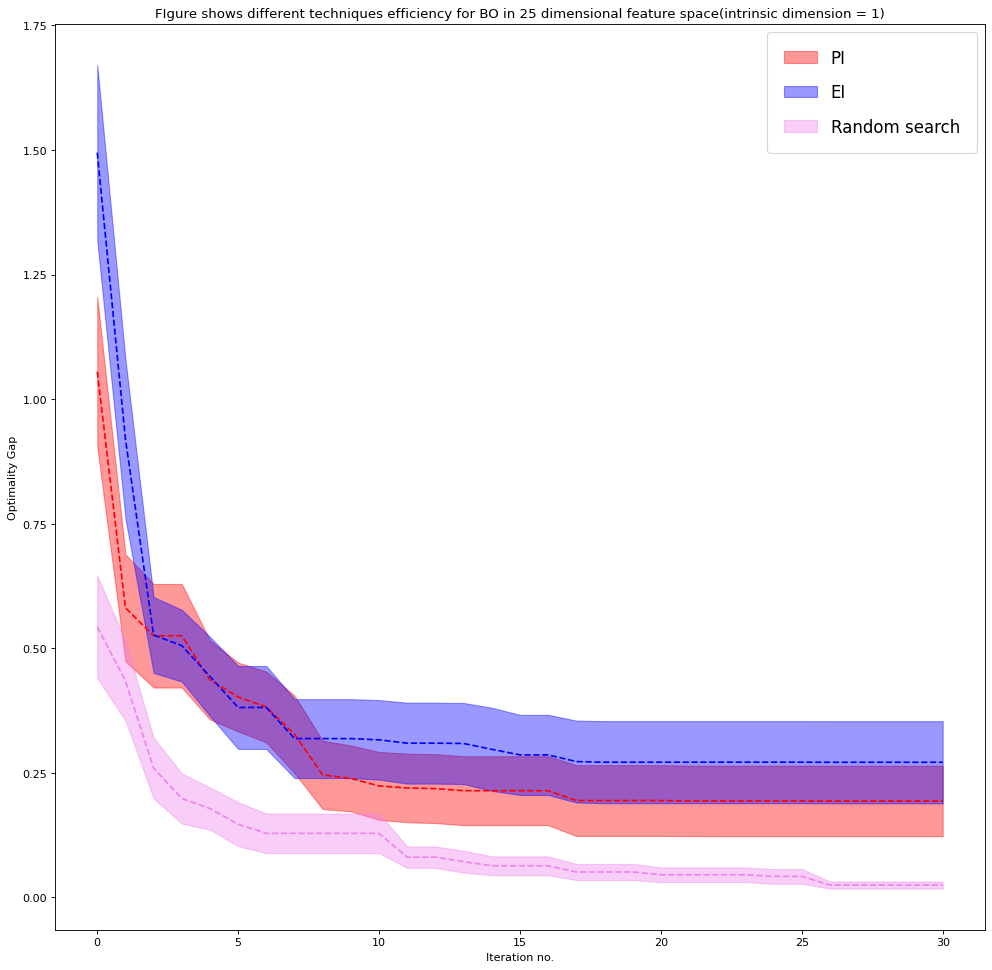

In [89]:
## plot showing optimality gap between max value obtained in each iteration and best value that can be obtained in the bound for two different aquisition functions - PI and EI. 
x = range(31)
y = []
y1 = []
y2 = []
for i in range(31):
  mean = np.mean(dp_PI[:,i])
  std = np.std(dp_PI[:,i])
  dev_up = np.max(dp_PI[:,i])
  dev_down = np.min(dp_PI[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)
  # y1.append(dev_up)
  # y2.append(dev_down)
fig = plt.figure(num=1, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.fill_between(x, y1, y2, color="red", alpha=0.4,label='PI')
ax.plot(x,y,'--',color='red')
x = range(31)
y = []
y1 = []
y2 = []
for i in range(31):
  mean = np.mean(dp_EI[:,i])
  std = np.std(dp_EI[:,i])
  dev_up = np.max(dp_EI[:,i])
  dev_down = np.min(dp_EI[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)

ax.fill_between(x, y1, y2, color="blue", alpha=0.4,label = 'EI')
ax.plot(x,y,'--',color='blue')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")

x = range(31)
y = []
y1 = []
y2 = []
for i in range(31):
  mean = np.mean(dp_random[:,i])
  std = np.std(dp_random[:,i])
  dev_up = np.max(dp_random[:,i])
  dev_down = np.min(dp_random[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)

ax.fill_between(x, y1, y2, color="violet", alpha=0.4,label = 'Random search')
ax.plot(x,y,'--',color='violet')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")
ax.set_title("FIgure shows different techniques efficiency for BO in 25 dimensional feature space(intrinsic dimension = 1)")

## 

plt.show(1)